In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandas_datareader.data as web
import yfinance as yf
import datetime
from datetime import date
from sklearn import metrics
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import ParameterGrid
from statsmodels.tsa.api import SimpleExpSmoothing, ExponentialSmoothing, Holt, seasonal_decompose
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tools.eval_measures import rmse, meanabs
from pmdarima.arima import auto_arima

%matplotlib inline

Time Series Eval Metrics Method

In [3]:
def ts_eval_metrics(y_true, y_pred):
    print('Time Series Evaluation Metrics')
    print(f'MSE = {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE = {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE = {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE = {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'r2 = {metrics.r2_score(y_true, y_pred)}', end='\n\n')

In [4]:
aapl = yf.Ticker("SPY")

### Plot an initial time series
##### Reference
##### Chaudhari, S. (2021). Stationarity in time series analysis explained using Python. Mathematics and Econometrics. https://blog.quantinsti.com/stationarity

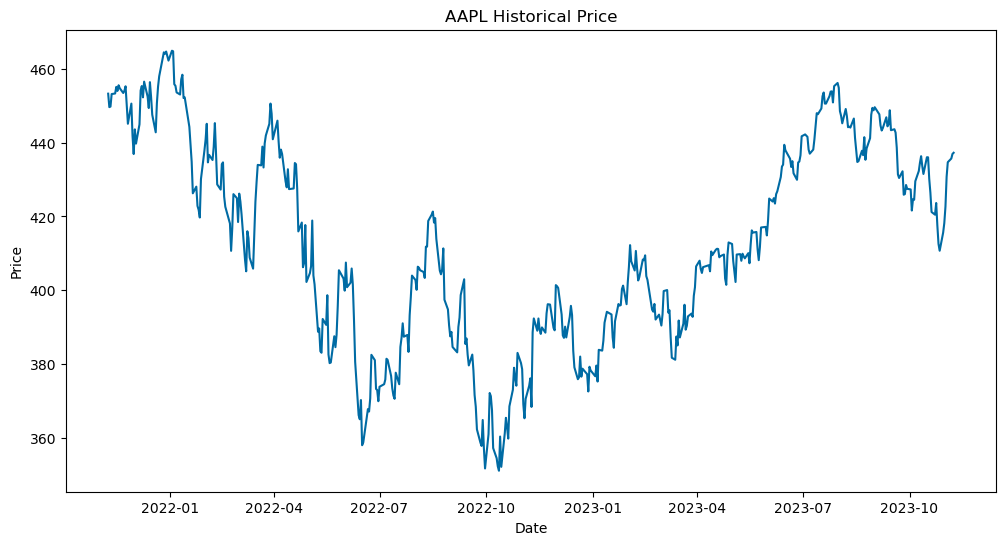

In [5]:
plt.style.use('tableau-colorblind10') #https://matplotlib.org/stable/gallery/style_sheets/style_sheets_reference.html
plt.figure(figsize=(12, 6))
close = aapl.history(period='24mo')['Close']
plt.plot(close)
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('AAPL Historical Price')
plt.show()

## Check stationarity

### Split Price into halves for statistical analysis

In [6]:
X = close.copy()
split = round(len(X)/2)
X1, X2 = X[0:split], X[split:]
mean1, mean2 = X1.mean(), X2.mean()
mean_percent_diff = (mean2 - mean1) / mean1 * 100
var1, var2 = X1.var(), X2.var()
var_percent_diff = (var2 - var1) / var1 * 100
print('mean1=%f, mean2=%3f, mean_percent_diff=%f' % (mean1, mean2, mean_percent_diff))
print('variance1=%f, variance2=%f, var_percent_diff=%f' % (var1, var2, var_percent_diff))

mean1=409.865479, mean2=415.032003, mean_percent_diff=1.260542
variance1=1011.205318, variance2=513.395513, var_percent_diff=-49.229350


### Augmented Dickey-Fuller Test
##### Check for stationarity where H0 = time series !stationary; H1 = time series = stationary
##### If p-value <= .05 or abs(test statistic)>critical value, reject H0

In [7]:
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
print(result[4])

ADF Statistic: -2.200498
p-value: 0.206065
Critical Values:
{'1%': -3.4434437319767452, '5%': -2.8673146875484368, '10%': -2.569845688481135}


##### P-value > .05; therefore, time series is not stationary (as expected).
##### abs(ADF Statistic) < abs(critical value) -> fail to reject H0
##### Therefore: Time series is not stationary for p-values .01, .05, and .1

### Kwiatkowski-Phillips-Schmidt-Shin test
##### KPSS is opposite of ADF where H0 = time series = stationary; H1 = time series !stationary
##### If p-value <= .05 || abs(KPSS test statistic)>critical value -> reject H0 -> therefore, !stationary

In [8]:
result = kpss(X)
print(result)
print('KPSS Test Statistic: %.2f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
print(result[3])

(0.8025678119949544, 0.01, 12, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})
KPSS Test Statistic: 0.80
p-value: 0.010000
Critical Values:
{'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}


C:\Users\rkartawi\AppData\Local\Temp\ipykernel_9540\2395884048.py:1: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(X)


##### P-value < .05; therefore, not stationary

### Transform into stationary series

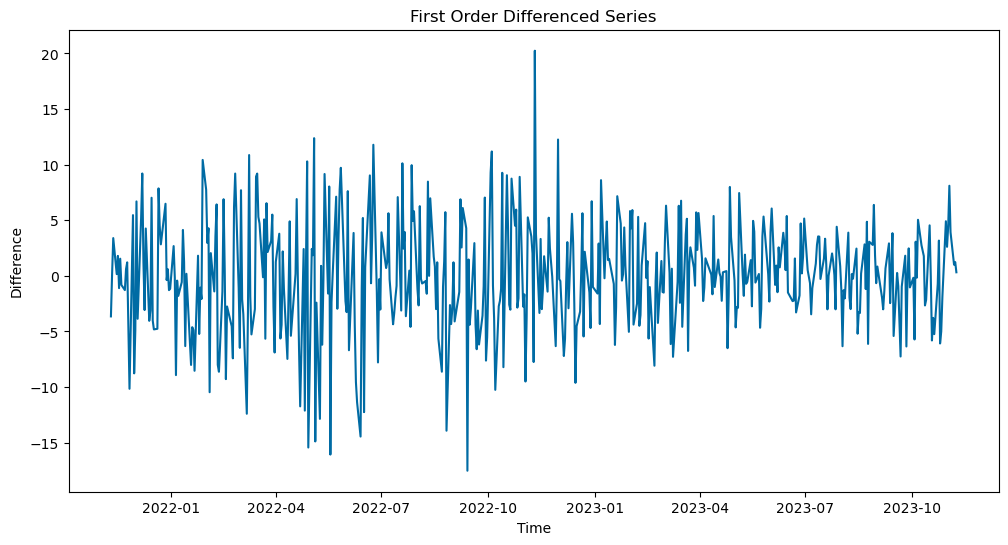

In [9]:
X['Difference'] = X.diff()
plt.figure(figsize=(12,6))
plt.plot(X['Difference'])
plt.title('First Order Differenced Series')
plt.xlabel('Time')
plt.ylabel('Difference')
plt.show()

In [10]:
result = adfuller(X.Difference.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
print(result[4])

ADF Statistic: -21.992557
p-value: 0.000000
Critical Values:
{'1%': -3.443470002903981, '5%': -2.867326248740681, '10%': -2.569851849873108}


(ADF) P-value < .05; therefore, AAPL price series is a difference-stationary series.

### Smoothing Methods
##### Reference
https://machinelearningmastery.com/exponential-smoothing-for-time-series-forecasting-in-python/

### Triple Exponential Smoothing
##### Use because we assume these time series have level, trends, seasonality, and noise
##### https://machinelearningmastery.com/how-to-grid-search-triple-exponential-smoothing-for-time-series-forecasting-in-python/

In [11]:
# Using method from Brownlee, J. (2020).
def exp_smoothing_forecast(history, config):
    t,d,s,p,b,r = config
    # define model model
    history = array(history)
    model = ExponentialSmoothing(history, trend=t, damped=d, seasonal=s, seasonal_periods=p)
    # fit model
    model_fit = model.fit(optimized=True, use_boxcox=b, remove_bias=r)
    # make one step forecast
    yhat = model_fit.predict(len(history), len(history))
    return yhat[0]

## Time Series Prediction
### Data partition
#### 2 years train; last 1 year validation

In [12]:
close = aapl.history(period='36mo')['Close']
print(len(close))
close_train = close.iloc[:506]
close_valid = close.iloc[-260:]

755


## Simple Exponential forecaster
### Plot an initial time series
##### Reference: Module 1

In [13]:
# Forecast 12 months ahead
ses_model = SimpleExpSmoothing(close_train).fit()

ses_pred = ses_model.forecast(steps=len(close_valid))
ses_eval_metrics = ts_eval_metrics(close_valid, ses_pred)

Time Series Evaluation Metrics
MSE = 1189.3435071354784
MAE = 27.83551955174705
RMSE = 34.48685991990976
MAPE = 0.06489193927441986
r2 = -1.1647031919720812



C:\Users\rkartawi\AppData\Local\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\rkartawi\AppData\Local\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\rkartawi\AppData\Local\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


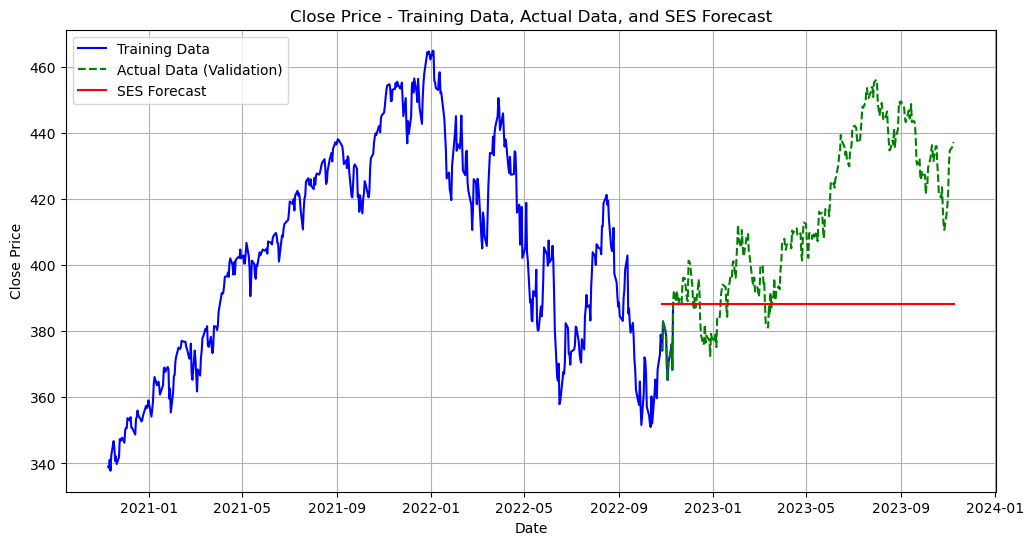

In [14]:
plt.figure(figsize=(12, 6))
plt.plot(close_train, label='Training Data', color='blue')
plt.plot(close_valid, label='Actual Data (Validation)', color='green', linestyle='--')
plt.plot(close_valid.index, ses_pred, label='SES Forecast', color='red')

plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Close Price - Training Data, Actual Data, and SES Forecast')
plt.legend()
plt.grid(True)
plt.show()

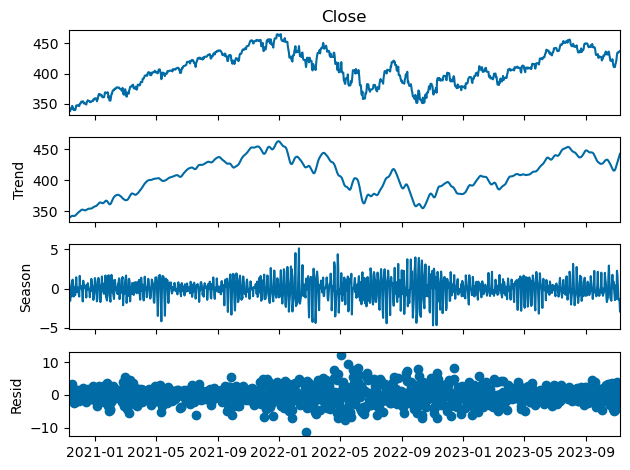

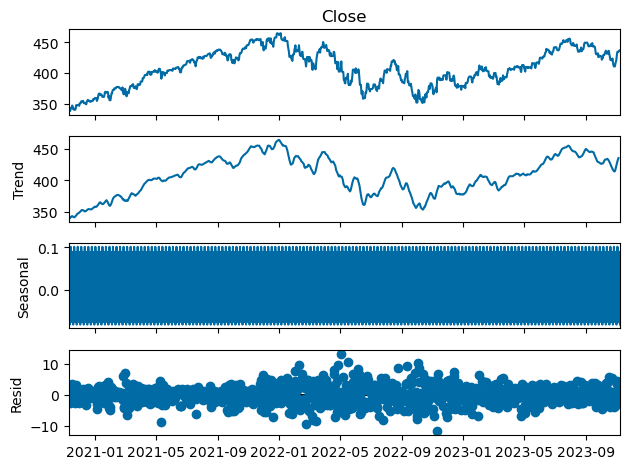

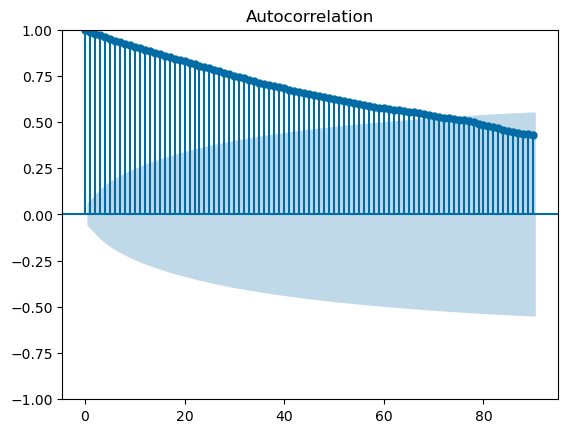

In [15]:
#### WORKING IN PROGRESS to be investigate ######

# #impute
close = close.asfreq('D')
close = close.ffill()

stl =  STL(close).fit()
stl.plot()
plt.show()

# decomposition = seasonal_decompose(close, model='additive')
# decomposition.plot()
# plt.show()

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# # Plot autocorrelation
plot_acf(close, lags=90)  # Adjust the number of lags as needed
plt.show()

#### to be investigate ######


In [16]:
aes_model = ExponentialSmoothing(close_train, 
                                 trend='add', # 'add', 'mul', 'additive', 'multiplicative', None
                                 damped_trend=True, #True, False
                                 seasonal= 'add', # 'mul', 'additive', 'multiplicative', None
                                 seasonal_periods= 65, 
                                 initialization_method='heuristic') #'estimated', 'heuristic', 'legacy-heuristic'
aes_model = aes_model.fit(smoothing_level=.1, smoothing_trend=0.1)

aes_pred = aes_model.forecast(steps=len(close_valid))
aes_eval_metrics = ts_eval_metrics(close_valid, aes_pred)
print(aes_eval_metrics)

Time Series Evaluation Metrics
MSE = 188.74605685685177
MAE = 11.683368251930727
RMSE = 13.73848815761224
MAPE = 0.028517043545567496
r2 = 0.6564666227217822

None


C:\Users\rkartawi\AppData\Local\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\rkartawi\AppData\Local\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\rkartawi\AppData\Local\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


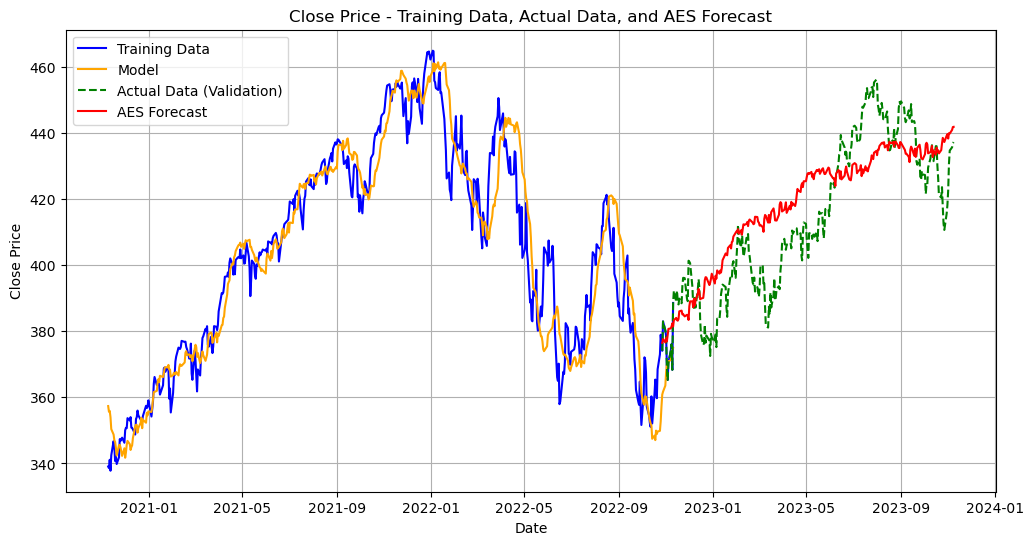

In [17]:
plt.figure(figsize=(12, 6))
plt.plot(close_train, label='Training Data', color='blue')
plt.plot(aes_model.fittedvalues, label="Model", color = 'orange')
plt.plot(close_valid, label='Actual Data (Validation)', color='green', linestyle='--')
plt.plot(close_valid.index, aes_pred, label='AES Forecast', color='red')

plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Close Price - Training Data, Actual Data, and AES Forecast')
plt.legend()
plt.grid(True)
plt.show()

https://machinelearningmastery.com/how-to-grid-search-triple-exponential-smoothing-for-time-series-forecasting-in-python/

In [18]:
### WORKING IN PROGRESS ###
# Auto regression integrated moving average; Find best (p,d,q) by using auto_arima function
auto_arima_model = auto_arima(close_train, seasonal=True, stepwise=True, trace=True)
auto_arima_model.summary()

#### WORKING IN PROGRESS ###

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3023.210, Time=0.51 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3016.689, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3018.628, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3018.623, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3014.901, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3019.352, Time=0.28 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.945 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  506
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -1506.451
Date:                Wed, 08 Nov 2023   AIC                           3014.901
Time:                        19:36:42   BIC                           3019.126
Sample:                             0   HQIC                          3016.558
                                - 506                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2        22.8343      1.115     20.481      0.000      20.649      25.019
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):                44.70
Prob(Q):                              0.81   Prob(JB):                         0.00
Heteroskedasticity (H):               4.39   Skew:                            -0.28
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.35
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [19]:
aapl.income_stmt

""


In [20]:
aapl.quarterly_income_stmt

""


In [21]:
aapl.balance_sheet

""


In [22]:
aapl.quarterly_cashflow

""


In [23]:
aapl.major_holders

,0,1
0,Previous Close,436.93
1,Open,437.55
2,Bid,436.60 x 900
3,Ask,436.62 x 1100
4,Day's Range,434.87 - 438.09
5,52 Week Range,374.77 - 459.44
6,Volume,61511941
7,Avg. Volume,83265579


In [24]:
aapl.institutional_holders

,0,1
0,Net Assets,393.77B
1,NAV,436.76
2,PE Ratio (TTM),22.03
3,Yield,1.56%
4,YTD Daily Total Return,15.53%
5,Beta (5Y Monthly),1.00
6,Expense Ratio (net),0.09%
7,Inception Date,1993-01-22


In [25]:
aapl.mutualfund_holders

In [26]:
aapl.news

[{'uuid': '69f7f8a2-0ec9-4f56-abaf-7f04e8e2876d',
  'title': 'Stock market news today: Nasdaq, S&P 500 extend longest win streaks since 2021',
  'publisher': 'Yahoo Finance',
  'link': 'https://finance.yahoo.com/news/stock-market-news-today-nasdaq-sp-500-extend-longest-win-streaks-since-2021-210547514.html',
  'providerPublishTime': 1699477547,
  'type': 'STORY',
  'thumbnail': {'resolutions': [{'url': 'https://s.yimg.com/uu/api/res/1.2/.p5Rrur5T.Vk3bD83LmveQ--~B/aD0zNDMzO3c9NTE1MDthcHBpZD15dGFjaHlvbg--/https://s.yimg.com/os/creatr-uploaded-images/2023-11/77e55f20-7e23-11ee-ab7f-911ef91afd05',
     'width': 5150,
     'height': 3433,
     'tag': 'original'},
    {'url': 'https://s.yimg.com/uu/api/res/1.2/V9G.AO0RrbbUGNJfTx8wWQ--~B/Zmk9ZmlsbDtoPTE0MDtweW9mZj0wO3c9MTQwO2FwcGlkPXl0YWNoeW9u/https://s.yimg.com/os/creatr-uploaded-images/2023-11/77e55f20-7e23-11ee-ab7f-911ef91afd05',
     'width': 140,
     'height': 140,
     'tag': '140x140'}]},
  'relatedTickers': ['QQQ', '^GSPC', '^IXIC',

In [27]:
yf.pdr_override()

y_symbols = ['^GSPC', 'ES=F', 'NQ=F', 'YM=F', '^RUT', '^DJT', '^GDAXI', '^N225', '^SSMI', '^STOXX50E', '^FCHI', '^GSPTSE', '^HSI', '000001.SS', '^KS11', '^NSEI', '^AXJO']
stocks = ['^SPX']

In [28]:
startdate = datetime.datetime(2020,3,16)
today = date.today()
enddate = today

In [29]:
indices = web.get_data_yahoo(y_symbols, start=startdate, end=enddate)
stocks = web.get_data_yahoo(stocks, start=startdate, end=enddate)

[*********************100%%**********************]  17 of 17 completed
[*********************100%%**********************]  1 of 1 completed


In [30]:
stocks

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-03-16,2508.590088,2562.979980,2380.939941,2386.129883,2386.129883,7805450000
2020-03-17,2425.659912,2553.929932,2367.040039,2529.189941,2529.189941,8370250000
2020-03-18,2436.500000,2453.570068,2280.520020,2398.100098,2398.100098,8799300000
2020-03-19,2393.479980,2466.969971,2319.780029,2409.389893,2409.389893,7956100000
2020-03-20,2431.939941,2453.010010,2295.560059,2304.919922,2304.919922,9053950000
...,...,...,...,...,...,...
2023-11-01,4201.270020,4245.640137,4197.740234,4237.859863,4237.859863,4224900000
2023-11-02,4268.259766,4319.720215,4268.259766,4317.779785,4317.779785,4669780000
2023-11-03,4334.229980,4373.620117,4334.229980,4358.339844,4358.339844,4570960000


In [31]:
aapl.history(period='1mo')

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Capital Gains
Date,,,,,,,,
2023-10-09 00:00:00-04:00,427.579987,432.880005,427.010010,432.290009,80374400,0.0,0.0,0.0
2023-10-10 00:00:00-04:00,432.940002,437.220001,432.529999,434.540009,78607300,0.0,0.0,0.0
2023-10-11 00:00:00-04:00,435.640015,436.579987,433.179993,436.320007,62451700,0.0,0.0,0.0
2023-10-12 00:00:00-04:00,436.950012,437.339996,431.230011,433.660004,81154200,0.0,0.0,0.0
2023-10-13 00:00:00-04:00,435.209991,436.450012,429.880005,431.500000,95143100,0.0,0.0,0.0
2023-10-16 00:00:00-04:00,433.820007,437.140015,433.570007,436.040009,75433200,0.0,0.0,0.0
2023-10-17 00:00:00-04:00,432.809998,438.140015,432.450012,436.019989,75324700,0.0,0.0,0.0
2023-10-18 00:00:00-04:00,434.190002,435.179993,429.089996,430.209991,93559800,0.0,0.0,0.0
2023-10-19 00:00:00-04:00,430.950012,432.820007,425.730011,426.429993,121323000,0.0,0.0,0.0


In [32]:
aapl.get_shares_full(start="2022-01-01", end=None)

In [33]:
opt_df = aapl.option_chain('2023-11-10')
call = opt_df.calls
put = opt_df.puts
put

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency
0,SPY231110P00300000,2023-11-02 13:50:08+00:00,300.0,0.01,0.00,0.01,0.0,0.0,2.0,0,1.531252,False,REGULAR,USD
1,SPY231110P00305000,2023-11-02 13:30:04+00:00,305.0,0.01,0.00,0.01,0.0,0.0,40.0,1060,1.468753,False,REGULAR,USD
2,SPY231110P00310000,2023-11-03 20:01:59+00:00,310.0,0.01,0.00,0.01,0.0,0.0,522.0,709,1.406253,False,REGULAR,USD
3,SPY231110P00315000,2023-11-06 14:30:05+00:00,315.0,0.01,0.00,0.01,0.0,0.0,200.0,1823,1.343753,False,REGULAR,USD
4,SPY231110P00320000,2023-11-03 13:51:07+00:00,320.0,0.01,0.00,0.01,0.0,0.0,2.0,315,1.281254,False,REGULAR,USD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126,SPY231110P00500000,2023-11-07 19:42:15+00:00,500.0,62.92,62.59,63.62,0.0,0.0,4.0,0,0.949219,True,REGULAR,USD
127,SPY231110P00505000,2023-10-20 19:49:15+00:00,505.0,83.05,67.59,68.62,0.0,0.0,1.0,0,1.006841,True,REGULAR,USD
128,SPY231110P00510000,2023-10-18 18:48:16+00:00,510.0,78.19,72.58,73.62,0.0,0.0,NaN,0,1.060552,True,REGULAR,USD
129,SPY231110P00530000,2023-10-10 14:16:10+00:00,530.0,94.79,92.58,93.62,0.0,0.0,1.0,0,1.276371,True,REGULAR,USD


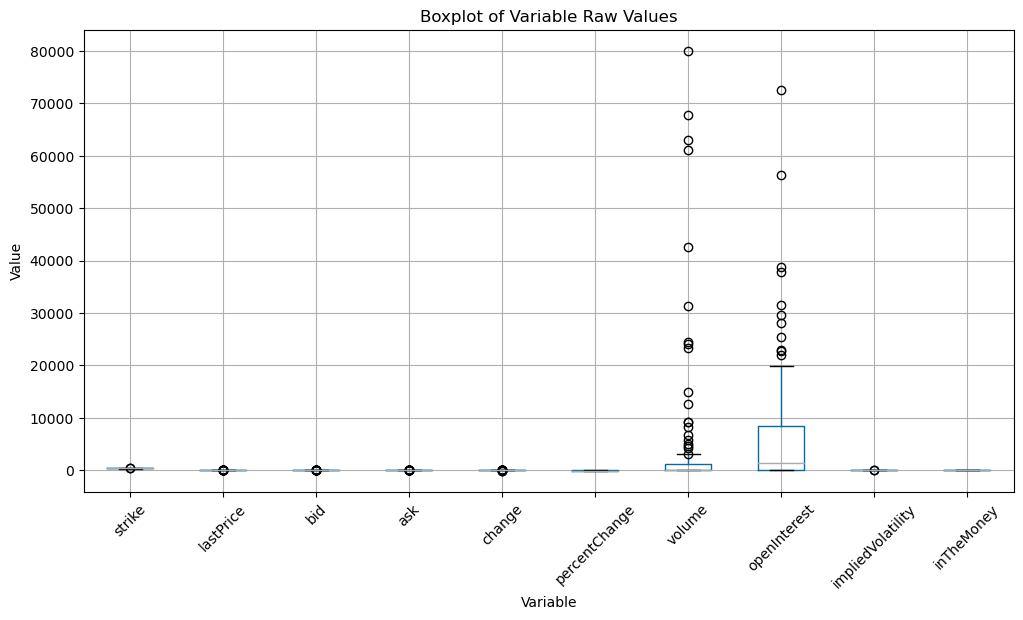

In [34]:
ax = put.boxplot(return_type='axes', rot=45, figsize=(12, 6))
ax.set_xlabel("Variable")
ax.set_ylabel("Value")
ax.set_title("Boxplot of Variable Raw Values")
plt.show()

In [35]:
put.describe()

,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility
count,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,128.000000,131.000000,131.000000
mean,408.171756,7.832137,6.584656,6.810840,-0.357023,-23.582429,4227.445312,6374.122137,0.547240
std,44.722683,19.182515,17.105523,17.396613,1.818525,25.468540,13083.796425,10935.370075,0.333111
min,300.000000,0.010000,0.000000,0.000000,-14.150000,-87.500000,1.000000,0.000000,0.129159
25%,377.500000,0.020000,0.010000,0.020000,-0.050000,-50.000000,9.750000,6.500000,0.272468
50%,410.000000,0.030000,0.020000,0.030000,-0.010000,-13.750007,102.500000,1444.000000,0.507817
75%,437.500000,1.810000,1.800000,1.815000,0.000000,0.000000,1268.000000,8485.500000,0.726565
max,540.000000,104.810000,102.580000,103.620000,0.620001,3.176620,79956.000000,72575.000000,1.531252


In [36]:
df_temp

NameError: name 'df_temp' is not defined

In [ ]:
aapl.options